# Setup

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d
from diffrax import Kvaerno3
import jax

np.set_printoptions(threshold=np.inf)

from jax import config
config.update("jax_enable_x64", True)

import sys
sys.path.append('..')

from hyrex.hyrex import recomb_model

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

# Running HyRex

In [82]:
h = jnp.float64(0.7)
omega_b = jnp.float64(0.0224)
omega_cdm = jnp.float64(0.12)
Neff = jnp.float64(3.044)
YHe = jnp.float64(0.245)
z_reion = 11
Delta_z_reion = 0.5

In [83]:
rmodel = recomb_model()

In [92]:
# wrap inputs in jnp.asarray to avoid recompilation
xe_full_reion, lna_full, Tm, lna_Tm = rmodel.get_history(jnp.asarray(h),
                                                         jnp.asarray(omega_b),
                                                         jnp.asarray(omega_cdm),
                                                         jnp.asarray(Neff),
                                                         jnp.asarray(YHe),
                                                         jnp.asarray(z_reion), # defaults to 11
                                                         jnp.asarray(Delta_z_reion) # defaults to 0.5
                                                        )

## An aside: `array_with_padding`

`get_history` returns an `array_with_padding` object.  This is because our differential equation solver `diffrax` pads output arrays with `jnp.inf` to maintain a fixed array size at compile time.  The arrays returned by this computation retain this padding, but `array_with_padding` has built-in functions meant to help you extract only the parts of the array with finite values.


So some care must be taken to extract array values.  Use either `.arr` or call with `()` to get array values:


In [93]:
z_full = jnp.exp(-lna_full.arr) - 1
print(z_full[-50:])
print(len(z_full))

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
25646


The end of the array is all -1, since the end of `lna_full.arr` is all `jnp.inf`.  Let's truncate the array before the `inf`s start with `.lastnum`:

In [94]:
z_full = jnp.exp(-lna_full.arr[:lna_full.lastnum]) - 1
print(z_full[-50:])
print(len(z_full))

[0.02564513 0.02513244 0.02462    0.02410782 0.02359589 0.02308422
 0.02257281 0.02206165 0.02155075 0.0210401  0.02052971 0.02001957
 0.01950969 0.01900006 0.01849069 0.01798157 0.01747271 0.0169641
 0.01645574 0.01594764 0.01543979 0.0149322  0.01442486 0.01391778
 0.01341094 0.01290436 0.01239804 0.01189197 0.01138615 0.01088058
 0.01037527 0.00987021 0.0093654  0.00886084 0.00835654 0.00785248
 0.00734868 0.00684513 0.00634184 0.00583879 0.005336   0.00483346
 0.00433117 0.00382913 0.00332734 0.0028258  0.00232451 0.00182347
 0.00132269 0.00082215]
17977


Note the array got shorter, and we only converted finite values of `lna_full` to `z` (no more padding at the end).

If you would like to access the last finite value of the output array, you can do so with `.lastval`:

In [95]:
last_lna = lna_full.lastval
print(last_lna)

-0.0003218128391413444


## Plotting HyRax results

Text(0, 0.5, '$x_e$')

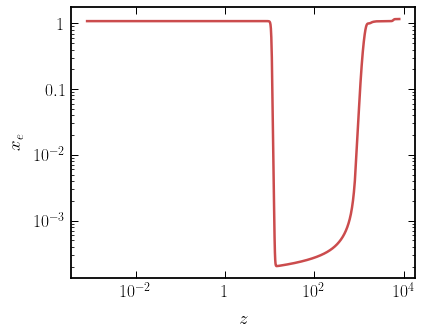

In [96]:
plt.loglog(z_full,xe_full_reion.arr[:xe_full_reion.lastnum])    # padding size is the same for lna_full and
                                                                # xe_full_reion, so either could be used to 
                                                                # index here
plt.xlabel('$z$')
plt.ylabel('$x_e$')

For easy comparison, we store some output of HYREC-2 in `notebooks/HYREC-2_results`, which was run with parameters
```
h = jnp.float64(0.674)
omega_b = jnp.float64(0.04)*h**2
omega_cdm = jnp.float64(0.26)*h**2
Neff = jnp.float64(3.044)
YHe = jnp.float64(0.245)
```
and can compare the results:

In [97]:
hyrec2out = np.loadtxt('HYREC-2_results/output_xe.dat')

In [98]:
z_hyrec = hyrec2out[:,0]
xe_hyrec = hyrec2out[:,1]
Tm_hyrec = hyrec2out[:,2]

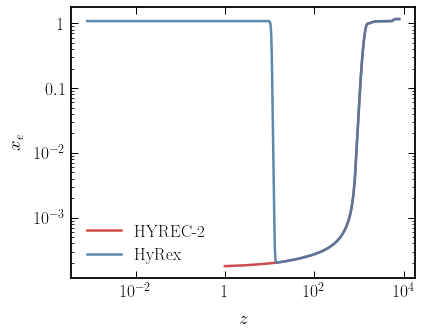

In [99]:
plt.loglog(z_hyrec,xe_hyrec,label='HYREC-2')
plt.loglog(z_full,xe_full_reion.arr[:xe_full_reion.lastnum],label='HyRex')


plt.xlabel('$z$')
plt.ylabel('$x_e$')

plt.legend()

The difference at low $z$ is due to reionization, which is not computed in HYREC-2 output.

We can add that in by hand (or alternatively set `z_reion` and `Delta_z_reion` to 0 in the HyRex call):

In [55]:
fHe = YHe / 4 / (1-YHe)
z = z_hyrec
y = (1+z)**(3./2)

y_reion = (1+z_reion)**(3./2)
Delta_y_reion = 3./2 * jnp.sqrt(1+z_reion) * Delta_z_reion
tanh_arg = (y_reion - y) / Delta_y_reion

xe_reion_correction = (1+fHe)/2 * (1 + jnp.tanh(tanh_arg))
hyrec_with_reion =  xe_hyrec + xe_reion_correction

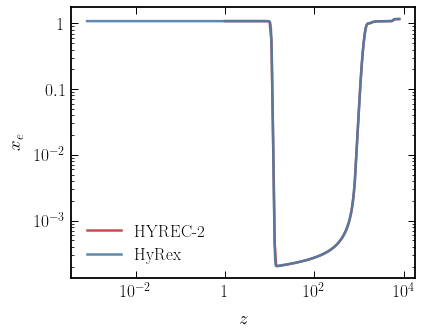

In [56]:
plt.loglog(z_hyrec,hyrec_with_reion,label='HYREC-2')
plt.loglog(z_full,xe_full_reion.arr[:xe_full_reion.lastnum],label='HyRex')


plt.xlabel('$z$')
plt.ylabel('$x_e$')

plt.legend()

We can see that the agreement sub percent-level:

Text(0, 0.5, '$\\frac{x_{e,{\\rm{HyRex}}} - x_{e,\\rm{HYREC2}}}{x_{e,\\rm{HYREC2}}}$')

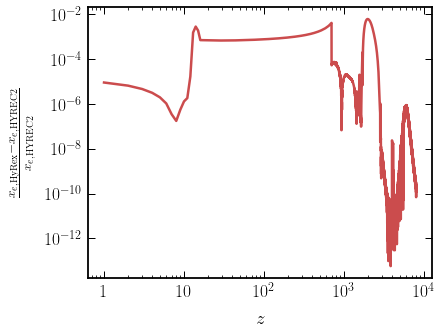

In [67]:
xe_hyrex_interp = interp1d(z_full,xe_full_reion.arr[:xe_full_reion.lastnum])
plt.loglog(z_hyrec,np.abs(xe_hyrex_interp(z_hyrec)-hyrec_with_reion)/hyrec_with_reion)
plt.xlabel('$z$')
plt.ylabel(r'$\frac{x_{e,{\rm{HyRex}}} - x_{e,\rm{HYREC2}}}{x_{e,\rm{HYREC2}}}$')

In [61]:
max(np.abs(xe_hyrex_interp(z_hyrec)-hyrec_with_reion)/hyrec_with_reion)

Array(0.00623644, dtype=float64)